# Marc Toneatto
## UISSC Assignment 4
## Prof. Kontokosta
## NYU CUSP 

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import os
import json
import geopandas as gpd
from geopandas import GeoDataFrame
import statsmodels.api as sm
import shapely
from shapely.geometry import Point
import geopy
from geopy.geocoders import Nominatim
import matplotlib
import matplotlib.pylab as plt
import pylab as pl
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller

#imports function for Weather API
from get_jsonparsed_data import get_jsonparsed_data

%matplotlib inline

# Part 1: Data Wrangling

### Sensor Data
 - Uploaded to PUIdata folder
 - Called using "PUIDATA" envar

In [2]:
data_path = os.getenv("PUIDATA")+"/LuxDustNoise_summarized_4hour_0719.csv"

In [3]:
sensor_data = pd.read_csv(data_path, parse_dates=True, index_col='dt')

In [4]:
sensor_data.head()

,sensor,lux,con,spl
dt,,,,
2016-06-21 00:00:00,sensor_0,0.0,2834.03125,66.308479
2016-06-21 00:00:00,sensor_2,0.0,1691.99625,70.375943
2016-06-21 00:00:00,sensor_3,0.0,1686.44125,76.235738
2016-06-21 00:00:00,sensor_4,0.0,2324.65875,70.652334
2016-06-21 04:00:00,sensor_0,3213.5,2748.28875,81.467436


### Sensor Locations

In [5]:
sensors = [{'sensor': 'sensor_0','Location' : 'RHI roof (at corner of Hicks and W 9th streets)'
            , 'Elevation (meters)': 8, 'Address': '767 Hicks St, Brooklyn, NY 11231', 
            'Location_Short':'RHI Roof (8m)' },
           {'sensor': 'sensor_2','Location' : 'TechLab (at ground level)'
            , 'Elevation (meters)': 0, 'Address': '106 Ferris Street, Brooklyn, NY 11231',
           'Location_Short':'TechLab (gl)'},
           {'sensor': 'sensor_3','Location' : 'RHI entrance (on Hicks street at street level)'
            , 'Elevation (meters)': 0, 'Address': '767 Hicks Street, Brooklyn, NY 11231',
            'Location_Short':'RHI Entrance (gl)'},
           {'sensor': 'sensor_4','Location' : 'PioneerWorks roof'
            , 'Elevation (meters)': 15, 'Address': '159 Pioneer St, Brooklyn, NY 11231',
           'Location_Short':'PioneerWorks Roof (15m)'}]

#Created dictionary from sensor locations provided

In [6]:
sensors_df = pd.DataFrame(sensors)
sensors_df = sensors_df[['sensor', 'Location', 'Elevation (meters)', 'Address', 'Location_Short']]

#Converting sensors dictionary to DataFrame, order comlumns

In [7]:
sensors_df.head()

,sensor,Location,Elevation (meters),Address,Location_Short
0,sensor_0,RHI roof (at corner of Hicks and W 9th streets),8,"767 Hicks St, Brooklyn, NY 11231",RHI Roof (8m)
1,sensor_2,TechLab (at ground level),0,"106 Ferris Street, Brooklyn, NY 11231",TechLab (gl)
2,sensor_3,RHI entrance (on Hicks street at street level),0,"767 Hicks Street, Brooklyn, NY 11231",RHI Entrance (gl)
3,sensor_4,PioneerWorks roof,15,"159 Pioneer St, Brooklyn, NY 11231",PioneerWorks Roof (15m)


In [8]:
geolocator = Nominatim()

In [9]:
#geocoding the sensor locations
sensors_df['Latitude'] = map(lambda x: geolocator.geocode(x).latitude, sensors_df['Address'])
sensors_df['Longitude'] = map(lambda x: geolocator.geocode(x).longitude, sensors_df['Address'])
sensors_df["geometry"] = sensors_df.apply(lambda row: Point(row["Longitude"], row["Latitude"]), axis=1)

In [10]:
sensors_df.head()

,sensor,Location,Elevation (meters),Address,Location_Short,Latitude,Longitude,geometry
0,sensor_0,RHI roof (at corner of Hicks and W 9th streets),8,"767 Hicks St, Brooklyn, NY 11231",RHI Roof (8m),40.676736,-74.004486,POINT (-74.0044858667069 40.6767364)
1,sensor_2,TechLab (at ground level),0,"106 Ferris Street, Brooklyn, NY 11231",TechLab (gl),40.677989,-74.017596,POINT (-74.0175965 40.67798885)
2,sensor_3,RHI entrance (on Hicks street at street level),0,"767 Hicks Street, Brooklyn, NY 11231",RHI Entrance (gl),40.676736,-74.004486,POINT (-74.0044858667069 40.6767364)
3,sensor_4,PioneerWorks roof,15,"159 Pioneer St, Brooklyn, NY 11231",PioneerWorks Roof (15m),40.679378,-74.011894,POINT (-74.011894 40.679378)


In [11]:
#creating a dataframe for each sensor
sensor0_daily = sensor_data[sensor_data['sensor']=='sensor_0'].resample('d').mean()
sensor2_daily = sensor_data[sensor_data['sensor']=='sensor_2'].resample('d').mean()
sensor3_daily = sensor_data[sensor_data['sensor']=='sensor_3'].resample('d').mean()
sensor4_daily = sensor_data[sensor_data['sensor']=='sensor_4'].resample('d').mean()

#Taking the daily mean of lux, con, and spl readings for each sensor

In [12]:
sensor0_daily['sensor'] = 'sensor_0'
sensor2_daily['sensor'] = 'sensor_2'
sensor3_daily['sensor'] = 'sensor_3'
sensor4_daily['sensor'] = 'sensor_4'

In [13]:
sensor0_daily.head()

,lux,con,spl,sensor
dt,,,,
2016-06-21,14226.979167,2717.245208,76.067465,sensor_0
2016-06-22,15952.750000,2522.080208,75.427829,sensor_0
2016-06-23,12436.000000,3633.355417,71.699026,sensor_0
2016-06-24,7185.000000,3270.930417,75.322384,sensor_0
2016-06-25,10543.958333,2758.851875,74.339227,sensor_0


In [14]:
#creating a dataframe for each measurement category
sensor_data_lum = sensor_data[['sensor','lux']]
sensor_data_sound = sensor_data[['sensor','spl']]
sensor_data_air = sensor_data[['sensor','con']]

In [15]:
#resampling each measurement category for the daily mean of readings
sensor_data_lum = sensor_data_lum.resample('d').mean()
sensor_data_sound = sensor_data_sound.resample('d').mean()
sensor_data_air = sensor_data_air.resample('d').mean()

In [16]:
sensor_data_air.head()

,con
dt,
2016-06-21,2437.804948
2016-06-22,2391.589531
2016-06-23,2875.919167
2016-06-24,2750.812708
2016-06-25,2388.765781


# Part 2: Plots, Daily Trends, Anomalous

In [17]:
def plot_sigma_scatter_by_sensor(df, dfb, sensor0, sensor2, sensor3, sensor4, label, legendlabel): 
    #plots the sensor data individually with a 3 sigma threshold
    pl.figure(figsize=(15,5))
    pl.scatter(df.index, dfb.where(df['sensor']==sensor0), c='b',label=sensor0)
    pl.scatter(df.index,dfb.where(df['sensor']==sensor2),c='g', label=sensor2)
    pl.scatter(df.index,dfb.where(df['sensor']==sensor3),c='r', label=sensor3)
    pl.scatter(df.index,dfb.where(df['sensor']==sensor4),c='c',label=sensor4)


    pl.plot([min(df.index),max(df.index)], [dfb.mean(axis=0), dfb.mean(axis=0)], 'y-', lw=2, label='Mean')
    pl.xticks(rotation = 75, fontsize=15)
    pl.xlim(min(df.index),max(df.index))
    pl.ylabel(label, fontsize=15)  
    pl.legend(loc='best')
    
    onesig = dfb.std(axis=0)

    tsthresh = (dfb.mean(axis=0) - (3 * onesig))
    poststhresh = (dfb.mean(axis=0) + (3 * onesig))
    
    print ("Negative 3 sigma threshold %.1f"%tsthresh)
    print ("Positive 3 sigma threshold %.1f"%poststhresh)
 
    pl.fill_between(df.index, dfb.mean(axis=0) - onesig, 
                    dfb.mean(axis=0) + onesig, alpha=0.5)
    plt.fill_between(df.index, dfb.mean(axis=0) - 2 * onesig,
                    dfb.mean(axis=0)+ 2 * onesig, alpha = 0.2)

    pl.fill_between(df.index, dfb.mean(axis=0) - 3 * onesig,
                    dfb.mean(axis=0)+ 3 * onesig, alpha = 0.2)

In [18]:
def plot_sigma_scatter(df, dfb, label, legendlabel): #plots the sensor data with a 3 sigma threshold
    pl.figure(figsize=(15,5))
    pl.scatter(df.index,dfb, label=legendlabel)
    pl.plot([min(df.index),max(df.index)], [dfb.mean(axis=0), dfb.mean(axis=0)], 'y-', lw=2, label='Mean')
    pl.xticks(rotation = 75, fontsize=15)
    pl.xlim(min(df.index),max(df.index))
    pl.ylabel(label, fontsize=15)  
    pl.legend(loc='best')
    
    onesig = dfb.std(axis=0)

    tsthresh = (dfb.mean(axis=0) - (3 * onesig))
    poststhresh = (dfb.mean(axis=0) + (3 * onesig))
    
    print ("Negative 3 sigma threshold %.1f"%tsthresh)
    print ("Positive 3 sigma threshold %.1f"%poststhresh)
 
    pl.fill_between(df.index, dfb.mean(axis=0) - onesig, 
                    dfb.mean(axis=0) + onesig, alpha=0.5)
    plt.fill_between(df.index, dfb.mean(axis=0) - 2 * onesig,
                    dfb.mean(axis=0)+ 2 * onesig, alpha = 0.2)

    pl.fill_between(df.index, dfb.mean(axis=0) - 3 * onesig,
                    dfb.mean(axis=0)+ 3 * onesig, alpha = 0.2)

Negative 3 sigma threshold -24665.5
Positive 3 sigma threshold 39610.4


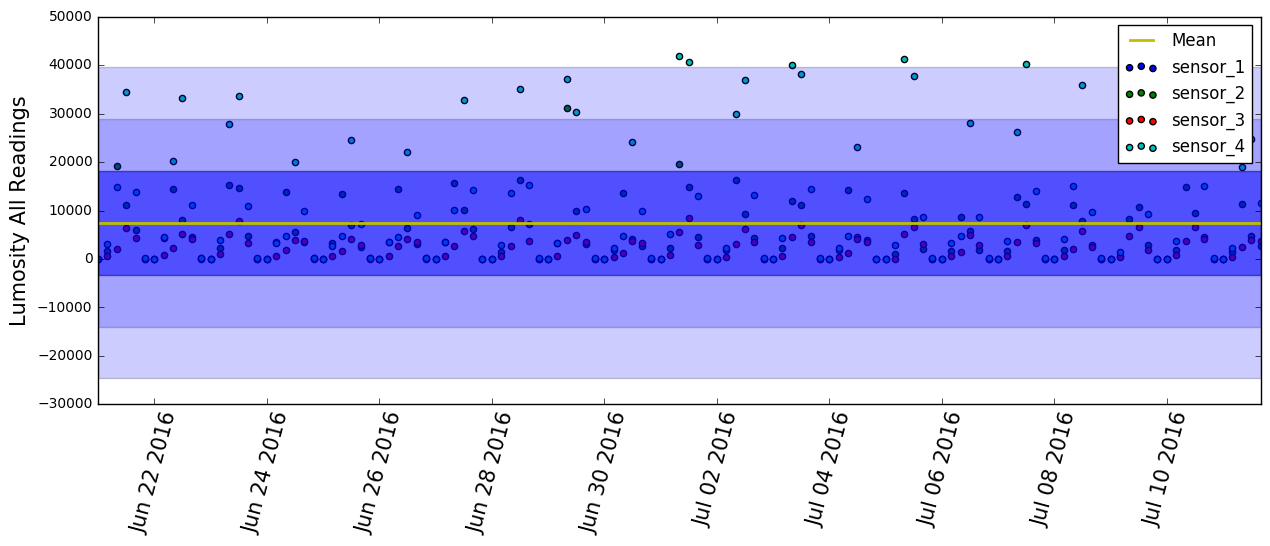

In [19]:
plot_sigma_scatter_by_sensor(sensor_data, sensor_data.lux, 'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4',
                             'Lumosity All Readings', "Lumosity")

### Figure 1: Lumosity All Readings
- The above scatter plot illustrates all data points recorded by all 4 sensors from 06/26/2016 through 07/11/2016.
- The yellow line illustrates the mean of all data points, while the blue shading represents 1 to 3 standard deviations away from the mean.
- This format will be follow for all measurements.
- As shown above in Figure 1, there are several data points which lay outside the three sigma (standard deviation) threshhold. These lumosity readings are considered "events" and will be evaluated further. 
- Daily Trend: Daily readings for all sensors appear cyclical. Daily readings begin at 0 and increase as the day progresses. This trend is expected as sensor reading coincide with sunlight. 

In [20]:
def event_id_all(df, dfb, measure, eventdf): 
    #identifies 3 sigma threshold, creates a dataframe with all points above or below
    onesig = dfb.std(axis=0)
    neg_tsthresh = (dfb.mean(axis=0) - (3 * onesig))
    pos_tsthresh = (dfb.mean(axis=0) + (3 * onesig))
    
    lo_df = df[dfb <= neg_tsthresh]
    hi_df = df[dfb >= pos_tsthresh]
    dfs = [lo_df,hi_df]
    eventdf = pd.DataFrame()
    eventdf = pd.concat(dfs)
    eventdf = eventdf[['sensor', measure]]
    print ("Total Event Data Points %.1f"%len(eventdf))
    return pd.DataFrame(eventdf)

In [21]:
lux_all_readings_events = event_id_all(sensor_data, sensor_data.lux,'lux', "lux_all_readings_events")
lux_all_readings_events
#Identifying the total number and values of lux events beyonf 3sigma

Total Event Data Points 14.0


,sensor,lux
dt,,
2016-06-21 12:00:00,sensor_0,40268.250
2016-06-22 12:00:00,sensor_0,44426.625
2016-07-01 04:00:00,sensor_0,44847.625
2016-07-01 08:00:00,sensor_4,41880.625
2016-07-01 12:00:00,sensor_4,40735.000
2016-07-02 04:00:00,sensor_0,43631.375
2016-07-02 08:00:00,sensor_0,40940.125
2016-07-03 04:00:00,sensor_0,41364.375
2016-07-03 08:00:00,sensor_4,40030.500


In [22]:
def plot_sigma(df, dfb, title, ylabel, legendlabel): #plots the daily mean of the sensor data with a 3 sigma threshold
    pl.figure(figsize=(15,5))
    pl.title(title, fontsize=20)
    pl.plot(df, 'k-', lw = 2, label=legendlabel)
    pl.plot([min(df.index),max(df.index)], [dfb.mean(axis=0), dfb.mean(axis=0)], 'y-', lw=2, label='Mean')
    pl.xticks(rotation = 75, fontsize=15)
    pl.ylabel(ylabel, fontsize=15)  
    pl.legend(loc='best')
    
   
    onesig = dfb.std(axis=0)

    tsthresh = (dfb.mean(axis=0) - (3 * onesig))
    poststhresh = (dfb.mean(axis=0) + (3 * onesig))
    print ("Negative 3 sigma threshold %.1f"%tsthresh)
    print ("Positive 3 sigma threshold %.1f"%poststhresh)
    #print ("outlier index", sensor_data.spl.where(sensor_data['spl'] < tsthresh))
    #print ("outlier date", sensor_data.index[sensor_data.where(sensor_data['spl'] < tsthresh)])

    pl.fill_between(df.index, dfb.mean(axis=0) - onesig, 
                    dfb.mean(axis=0) + onesig, alpha=0.5)
    plt.fill_between(df.index, dfb.mean(axis=0) - 2 * onesig,
                    dfb.mean(axis=0)+ 2 * onesig, alpha = 0.2)

    pl.fill_between(df.index, dfb.mean(axis=0) - 3 * onesig,
                    dfb.mean(axis=0)+ 3 * onesig, alpha = 0.2)


Negative 3 sigma threshold 1931.3
Positive 3 sigma threshold 13013.9


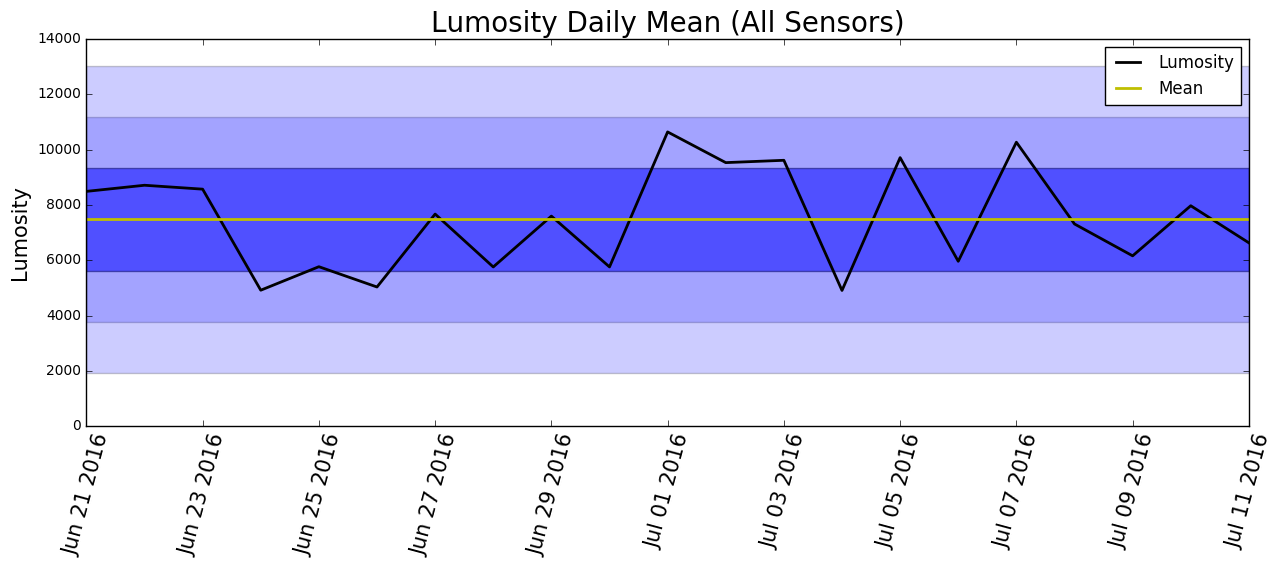

In [23]:
plot_sigma(sensor_data_lum['lux'],sensor_data_lum.lux, "Lumosity Daily Mean (All Sensors)",
           "Lumosity",'Lumosity')

### Figure 2: Lumosity Daily Mean (All Sensors)
- The above plot shows the daily mean for lumosity readings for all 4 sensors. 
- There are no data points which lay outside the 3 sigma theshhold. The mean of the readings appear to normalize the data. 
- Observing the mean of all 4 sensors is beneficial in that due to the close proximity of the sensors identify any community-wide weather anomolies. However, by aggregating the readings individual reading outliers are lost. In this case, individual reading outliers are the subject of observation and will be evaluated futher. 

In [24]:
def event_id_dmean(df, dfb, measure, eventdf): 
    #identifies 3 sigma threshold for daily mean, creates a dataframe with all points above or below
    onesig = dfb.std(axis=0)
    neg_tsthresh = (dfb.mean(axis=0) - (3 * onesig))
    pos_tsthresh = (dfb.mean(axis=0) + (3 * onesig))
    
    lo_df = df[dfb <= neg_tsthresh]
    hi_df = df[dfb >= pos_tsthresh]
    dfs = [lo_df,hi_df]
    eventdf = pd.DataFrame()
    eventdf = pd.concat(dfs)
    eventdf = eventdf[[measure]]
    print ("Total Event Data Points %.1f"%len(eventdf))
    return pd.DataFrame(eventdf)

In [25]:
event_id_dmean(sensor_data_lum, sensor_data_lum.lux, 'lux', "lux_daily_mean_events")
#testing to prove there are no daily mean points outside 3 sigma

Total Event Data Points 0.0


,lux
dt,


In [26]:
def event_id_4(sensor0,sensor2,sensor3,sensor4, measure, eventdf): 
    #identifies 3 sigma threshold, creates a dataframe with all points above or below
    
    onesig0 = sensor0.std(axis=0)
    neg_tsthresh0 = (sensor0.mean(axis=0) - (3 * onesig0))
    pos_tsthresh0 = (sensor0.mean(axis=0) + (3 * onesig0))
    lo_df0 = sensor0_daily[sensor0 <= neg_tsthresh0]
    hi_df0 = sensor0_daily[sensor0 >= pos_tsthresh0]
    
    onesig2 = sensor2.std(axis=0)
    neg_tsthresh2 = (sensor2.mean(axis=0) - (3 * onesig2))
    pos_tsthresh2 = (sensor2.mean(axis=0) + (3 * onesig2))
    lo_df2 = sensor2_daily[sensor2 <= neg_tsthresh2]
    hi_df2 = sensor2_daily[sensor2 >= pos_tsthresh2]

    
    onesig3 = sensor3.std(axis=0)
    neg_tsthresh3 = (sensor3.mean(axis=0) - (3 * onesig3))
    pos_tsthresh3 = (sensor3.mean(axis=0) + (3 * onesig3))
    lo_df3 = sensor3_daily[sensor3 <= neg_tsthresh3]
    hi_df3 = sensor3_daily[sensor3 >= pos_tsthresh3]
    
    onesig4 = sensor4.std(axis=0)
    neg_tsthresh4 = (sensor4.mean(axis=0) - (3 * onesig4))
    pos_tsthresh4 = (sensor4.mean(axis=0) + (3 * onesig4))
    lo_df4 = sensor4_daily[sensor4 <= neg_tsthresh4]
    hi_df4 = sensor4_daily[sensor4 >= pos_tsthresh4]
    
    
    
    
    
    dfs = [lo_df0,lo_df2,lo_df3,lo_df4,hi_df0,hi_df2,hi_df3,hi_df4]
    eventdf = pd.DataFrame()
    eventdf = pd.concat(dfs)
    eventdf = eventdf[['sensor', measure]]
    return eventdf 

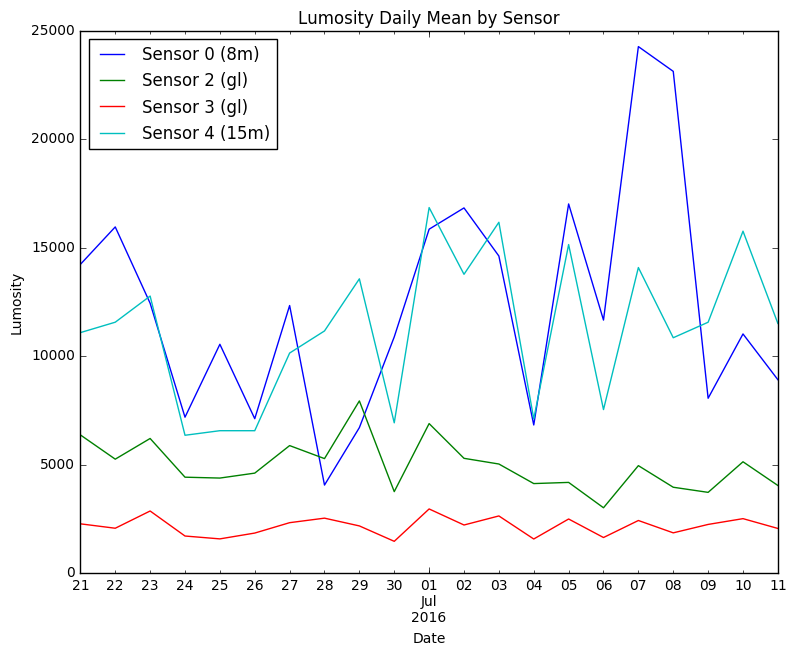

In [27]:
plt.figure(figsize=(9,7))
sensor0_daily['lux'].plot(label='Sensor 0 (8m)')
sensor2_daily['lux'].plot(label='Sensor 2 (gl)')
sensor3_daily['lux'].plot(label='Sensor 3 (gl)')
sensor4_daily['lux'].plot(label='Sensor 4 (15m)')
plt.ylabel('Lumosity')
plt.xlabel('Date')
plt.title('Lumosity Daily Mean by Sensor')
plt.legend(loc='best')

### Figure 3: Lumosity Daily Mean by Sensor
- The above plot shows the daily mean for lumosity readings by sensor. 
- Sensors 0 and 4 clearly display regularly higher readings for lumosity than sensors 2 and 3. This may be attributable to altitude and sensors 0 and 4 are located on rooftops and sensors 2 and 3 are located on ground level.
- Due to the differences in altitide and regular sun exposure, it would be more benficial to observe events in the daily mean by each sensor individually. 

In [60]:
def sigma_plot_4 (sensor0, sensor2, sensor3, sensor4,ylabel, xlabel,):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(13,7))
    
    ax1.plot(sensor0, color='b', lw=2, label= ylabel)
    ax1.set_title('Sensor 0 (8m)')
    ax1.set_ylabel(ylabel)
    ax1.plot([min(sensor0.index),max(sensor0.index)], [sensor0.mean(axis=0), sensor0.mean(axis=0)], 'y-', lw=2, 
             label='Mean')
    ax1.legend(loc='best')

    ax1_onesig = sensor0.std(axis=0)

    ax1.fill_between(sensor0.index, sensor0.mean(axis=0) - ax1_onesig,
                sensor0.mean(axis=0) + ax1_onesig, alpha=0.5)

    ax1.fill_between(sensor0.index, sensor0.mean(axis=0) - 3 * ax1_onesig,
                sensor0.mean(axis=0)+ 3 * ax1_onesig, alpha = 0.2)


    ax2.plot(sensor2, color='g', lw=2, label = ylabel)
    ax2.set_title('Sensor 2 (gl)')
    ax2.plot([min(sensor2.index),max(sensor2.index)], [sensor2.mean(axis=0), sensor2.mean(axis=0)], 'y-', lw=2, 
            label = 'Mean')
    ax2.legend(loc='best')
    ax2_onesig = sensor2.std(axis=0)

    ax2.fill_between(sensor2.index, sensor2.mean(axis=0) - ax2_onesig,
                     sensor2.mean(axis=0) + ax2_onesig, alpha=0.5)

    ax2.fill_between(sensor2.index, sensor2.mean(axis=0) - 3 * ax2_onesig,
                     sensor2.mean(axis=0)+ 3 * ax2_onesig, alpha = 0.2)

    ax3.plot(sensor3, color='r', lw=2, label=ylabel)
    ax3.set_title('Sensor 3 (gl)')
    ax3.set_ylabel(ylabel)
    ax3.set_label(xlabel)
    ax3.plot([min(sensor3.index),max(sensor3.index)], [sensor3.mean(axis=0), sensor3.mean(axis=0)], 'y-', lw=2, 
            label='Mean')
    ax3.legend(loc='best')
    
    ax3_onesig = sensor3.std(axis=0)

    ax3.fill_between(sensor3.index, sensor3.mean(axis=0) - ax3_onesig,
                     sensor3.mean(axis=0) + ax3_onesig, alpha=0.5)

    ax3.fill_between(sensor3.index,sensor3.mean(axis=0) - 3 * ax3_onesig,
                     sensor3.mean(axis=0)+ 3 * ax3_onesig, alpha = 0.2)


    ax4.plot(sensor4, color='c', lw=2, label=ylabel)
    ax4.set_title('Sensor 4 (15m)')
    ax4.plot([min(sensor4.index),max(sensor4.index)], [sensor4.mean(axis=0), sensor4.mean(axis=0)], 'y-', lw=2,
            label='Mean')
    ax4.legend(loc='best')

    ax4_onesig = sensor4.std(axis=0)

    ax4.fill_between(sensor4.index, sensor4.mean(axis=0) - ax4_onesig,
                     sensor4.mean(axis=0) + ax4_onesig, alpha=0.5)

    ax4.fill_between(sensor4.index,sensor4.mean(axis=0) - 3 * ax4_onesig,
                     sensor4.mean(axis=0)+ 3 * ax4_onesig, alpha = 0.2)
    
    


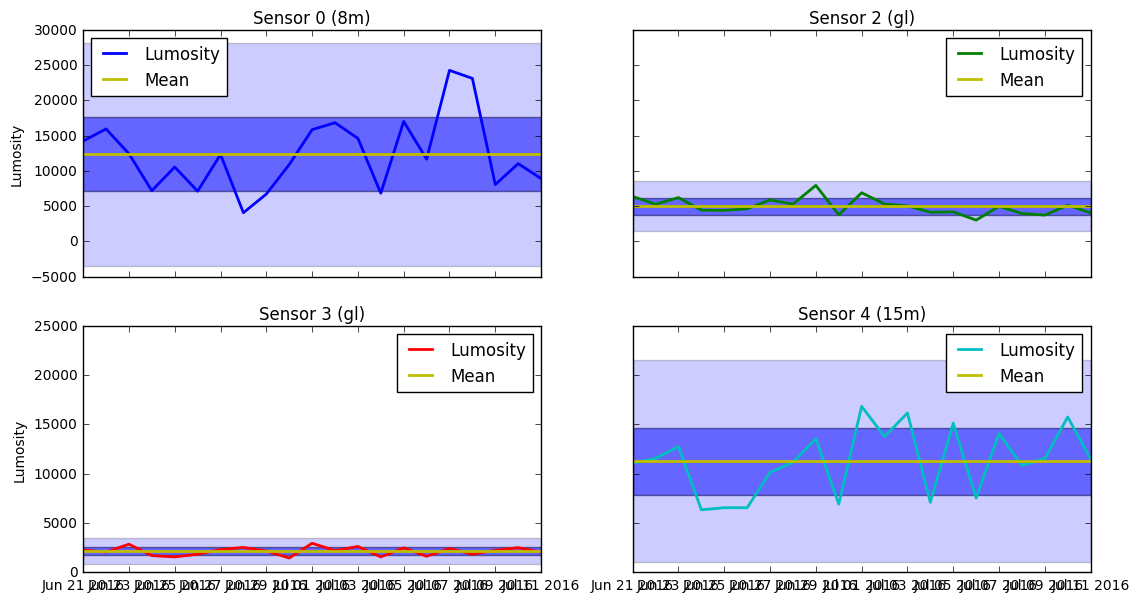

In [61]:
sigma_plot_4(sensor0_daily['lux'], sensor2_daily['lux'], sensor3_daily['lux'], sensor4_daily['lux'],
            'Lumosity', 'Date')

### Figure 4: Lumosity Daily Mean by Sensor
- The above plot shows the daily mean for lumosity readings by sensor (gl=ground level). 
- In each subplot, the mean and 3 sigma threshold are calculated. 
- After observation of daily mean for each sensor, there are no events beyong the 3sigma threshhold. 
    -This may be attributable to the simple cycle of daylight. The sensors readings are lower or nil after sunset and before sunrise. These low readings will shift the daily mean down and normalize events that may occur during the day. 


In [30]:
event_id_4(sensor0_daily['lux'], sensor2_daily['lux'], sensor3_daily['lux'], sensor4_daily['lux'],
            'lux', 'lux_daily_mean_events_bysensor')
#Running event ID function to prove no events beyond 3 sigma threshold

,sensor,lux
dt,,


# Particle Contents

Negative 3 sigma threshold -6090.6
Positive 3 sigma threshold 11973.6


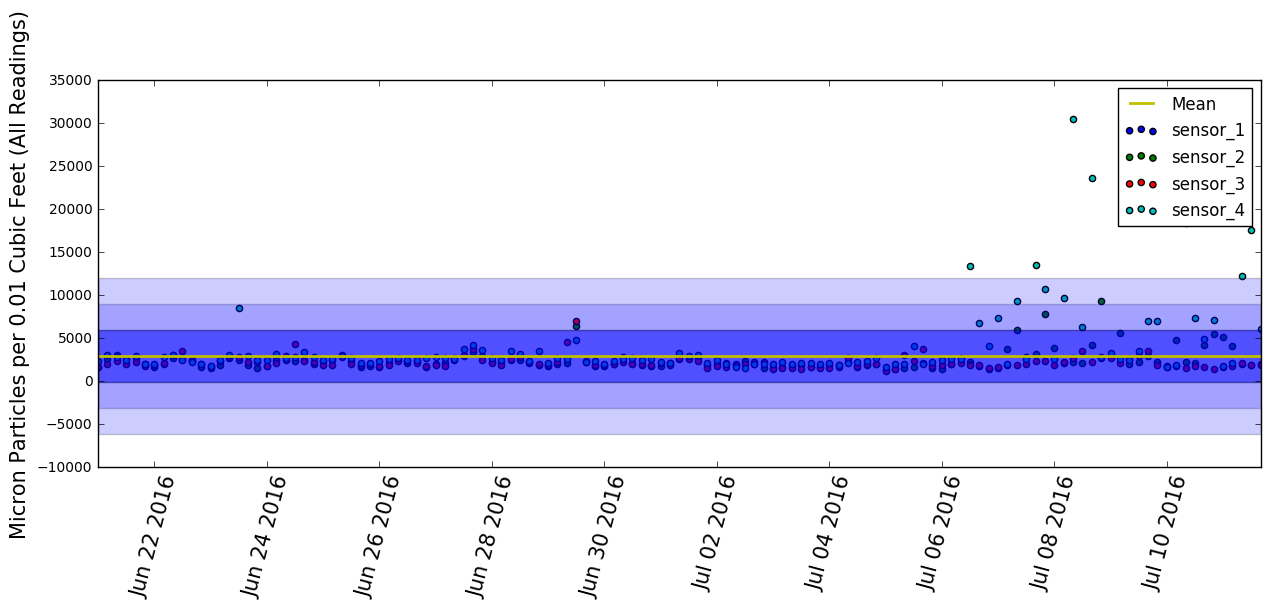

In [31]:
plot_sigma_scatter_by_sensor(sensor_data, sensor_data.con, 'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4',
                             "Micron Particles per 0.01 Cubic Feet (All Readings)","Particle Contents")

### Figure 5: Micron Particles per 0.01 cubic feet
- The above scatter plot shows all sensor readings for particle contents. The measurement details for this reading were found in the source provided (http://www.howmuchsnow.com/arduino/airquality/grovedust/)
- There are several data points that exceed the 3sigma threshhold but the vast majority of points lay within 1 standard deviation from the mean. 
- Daily Trend: The particle contents readings do not appear in an identifiable pattern as do the lumosity readings. Further investigation is needed to detertimine the role of sensor altitude in readings as well as the causes of the outliers.

In [32]:
#Event Detection
con_events_all_readings = event_id_all(sensor_data, sensor_data.con,'con', "con_events_all_readings")
con_events_all_readings

Total Event Data Points 8.0


,sensor,con
dt,,
2016-06-27 20:00:00,sensor_0,42612.26500
2016-07-06 12:00:00,sensor_4,13388.50000
2016-07-07 16:00:00,sensor_4,13499.98500
2016-07-08 08:00:00,sensor_4,30462.65750
2016-07-08 16:00:00,sensor_4,23540.73000
2016-07-10 08:00:00,sensor_4,18395.09500
2016-07-11 08:00:00,sensor_4,12186.73375
2016-07-11 12:00:00,sensor_4,17538.62250


Negative 3 sigma threshold -83.3
Positive 3 sigma threshold 6062.2


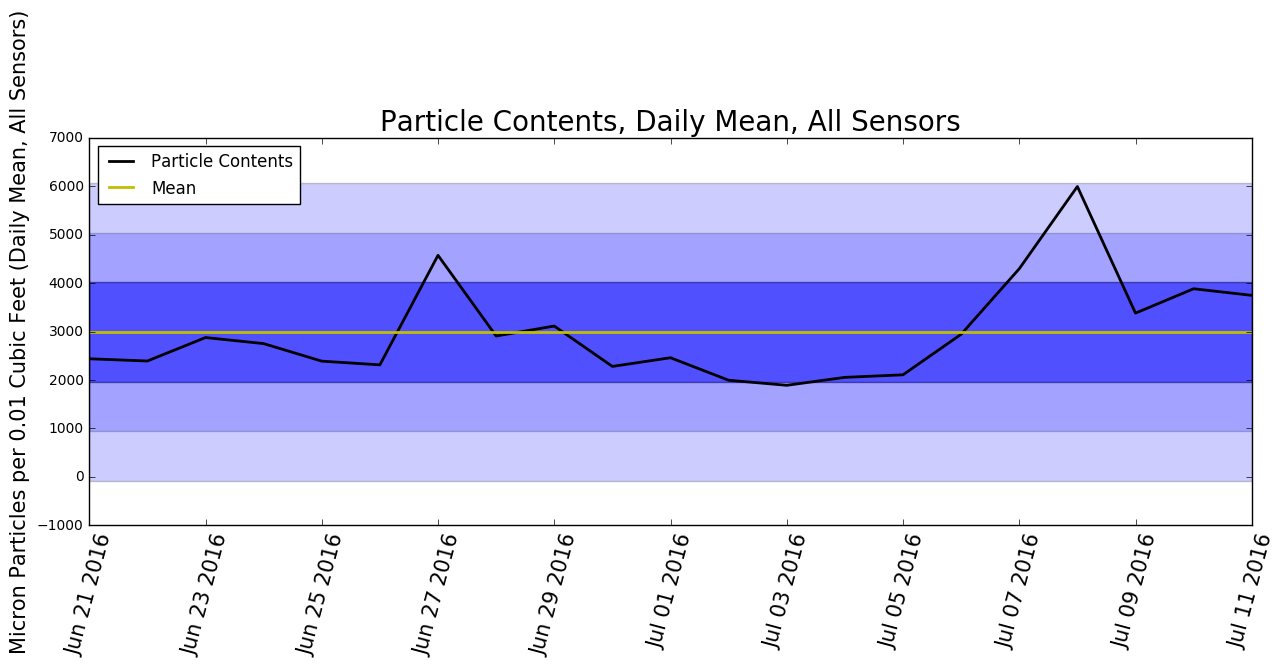

In [33]:
plot_sigma(sensor_data_air, sensor_data_air.con, "Particle Contents, Daily Mean, All Sensors", 
           "Micron Particles per 0.01 Cubic Feet (Daily Mean, All Sensors)", "Particle Contents")

### Figure 6: Particle Contents (All Sensors, Daily Mean)
- The values shown in the above plot were calculated based on the combined daily mean for all 4 sensors. The result shows several peaks and valleys but no data points beyond 3sigma threshhold. 
- As with the lumosity daily mean shown above, the outliers in individual readings are normalized when calculating the daily mean.

In [34]:
#Event Detection
event_id_dmean(sensor_data_air, sensor_data_air.con, 'con', "con_events_dmean")

Total Event Data Points 0.0


,con
dt,


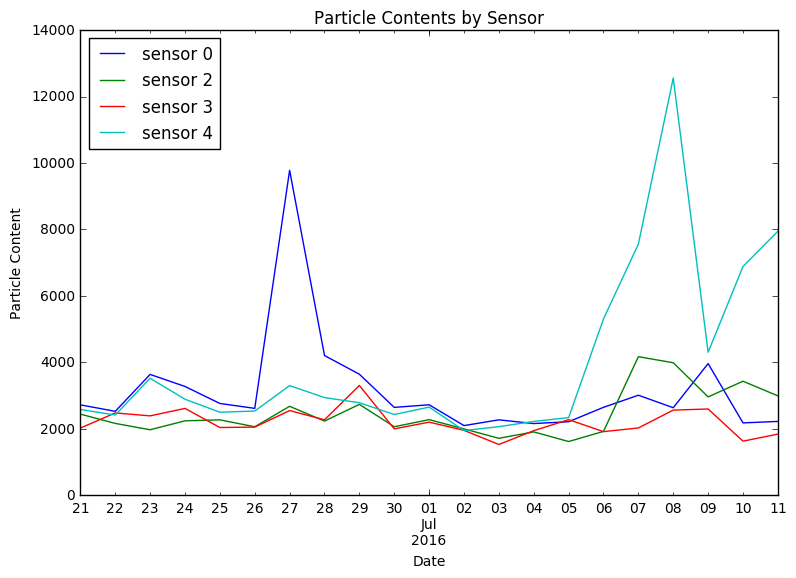

In [35]:
plt.figure(figsize=(9,6))
sensor0_daily['con'].plot(label='sensor 0')
sensor2_daily['con'].plot(label='sensor 2')
sensor3_daily['con'].plot(label='sensor 3')
sensor4_daily['con'].plot(label= 'sensor 4')
plt.title('Particle Contents by Sensor')
plt.xlabel('Date')
plt.ylabel('Particle Content')
plt.legend(loc='best')

### Figure 7: Lumosity Daily Mean by Sensor
- The above plot shows the daily mean for particle content readings by sensor. 
- Sensors 0 and 4 clearly display two high peaks, both occurences are independent of readings from the other sensors. 
    - On June 27, it appears that all sensors' daily mean readings spike, with the most extreme readings produced by sensor 0. 
- Daily Pattern: Although the two highest readings are from the higher altititude sensors, readings for particular contents do not appear to be as influenced by sensor placement height as lumosity. 

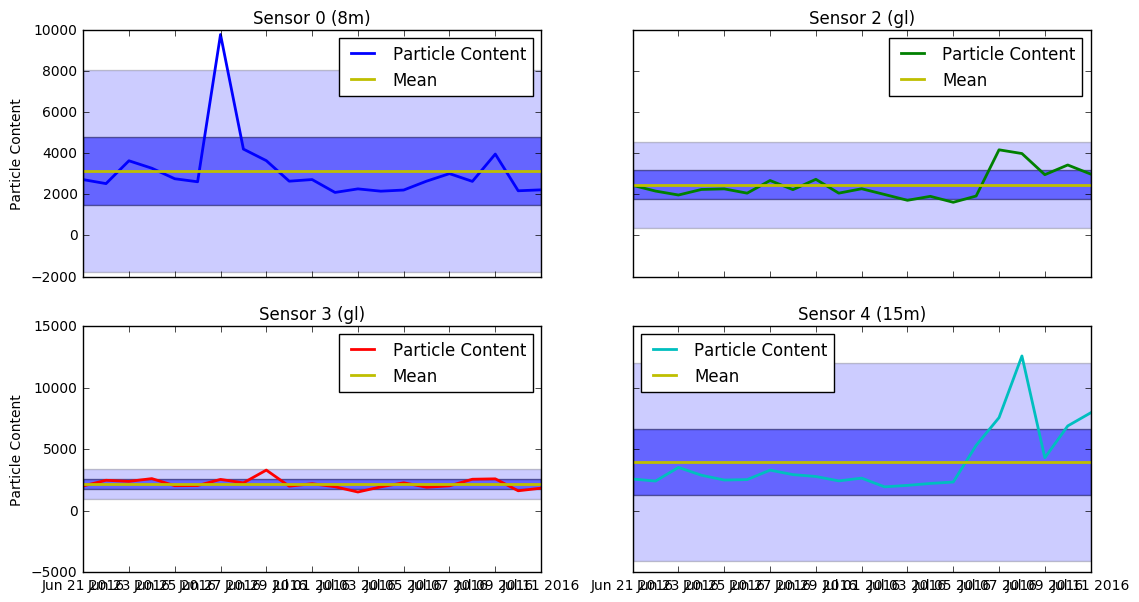

In [36]:
sigma_plot_4(sensor0_daily['con'], sensor2_daily['con'], sensor3_daily['con'], sensor4_daily['con'],
            'Particle Content', 'Date')

### Figure 8: Particle Content by Sensor (Daily Mean)
- The above plot shows the daily mean for particle content (Micron Particles per 0.01 Cubic Feet) readings by sensor (gl=ground level). 
- In each subplot, the mean and 3 sigma threshold are calculated. Plotting each sensors' daily mean independent of the others enables the observation of outliers unique to the observed sensors' location and altitude. Sensors 0 and 4 both display daily mean readings beyond the 3 sigma threshold.

In [37]:
con_events_sensor_dailym = event_id_4(sensor0_daily.con, sensor2_daily.con, sensor3_daily.con, 
           sensor4_daily.con, "con", "con_events_sensor_dailym")
con_events_sensor_dailym
#To identify the 2 particle content reading events

,sensor,con
dt,,
2016-06-27,sensor_0,9778.699583
2016-07-08,sensor_4,12558.187708


# Sound Pressure Level in dB (SPL)

Negative 3 sigma threshold 62.0
Positive 3 sigma threshold 88.0


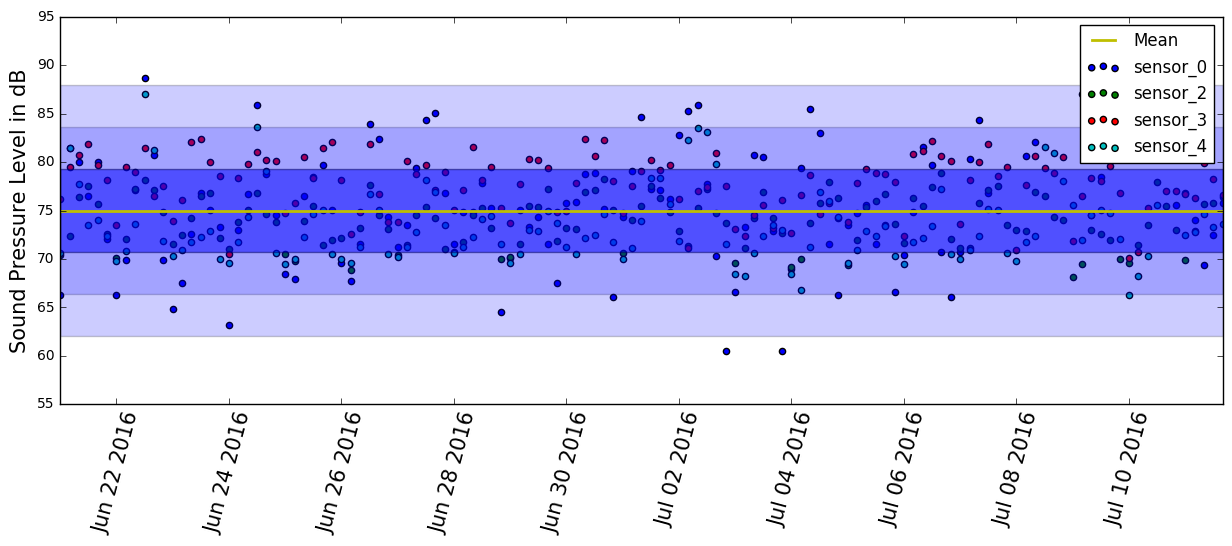

In [38]:
plot_sigma_scatter_by_sensor(sensor_data, sensor_data.spl, 
                             "sensor_0", "sensor_2", "sensor_3", "sensor_4", "Sound Pressure Level in dB"
                             , "spl")

### Figure 9: Sound Pressure Level in dB
- The above plot illustrates all SPL data points recorded by all 4 sensors. 
- The SPL readings are distrubuted fairly evenly above and below the mean, with 3 points beyond the 3 sigma threshold. 
- These results would indicate that the area within proximity to the sensors are not consistently noisy nor quiet. 
- Further investigation is needed to identify the role of altitude to the individual sensor readings

In [39]:
spl_events_all_readings = event_id_all(sensor_data, sensor_data.spl, 'spl', "spl_events_all_readings")
spl_events_all_readings

Total Event Data Points 3.0


,sensor,spl
dt,,
2016-07-02 20:00:00,sensor_0,60.547179
2016-07-03 20:00:00,sensor_0,60.547179
2016-06-22 12:00:00,sensor_0,88.647875


Negative 3 sigma threshold 71.7
Positive 3 sigma threshold 78.3


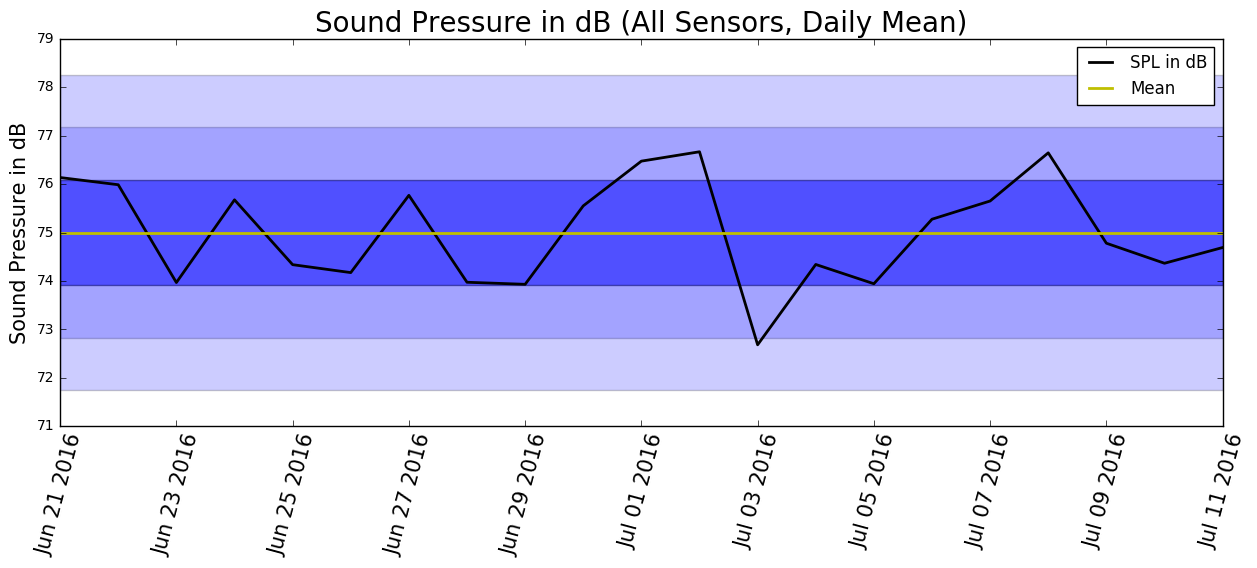

In [40]:
plot_sigma(sensor_data_sound, sensor_data_sound.spl, "Sound Pressure in dB (All Sensors, Daily Mean)",
           "Sound Pressure in dB", "SPL in dB")

### Figure 10: Sound Pressure Level in dB
- The above plot illustrates the daily mean in SPL readings recorded by all 4 sensors. 
- The SPL readings are distrubuted fairly evenly above and below the mean
- As with the other measurements, high levels of sound may not occur for long periods of time, which would cause the daily mean calulation to normalize the outliers and events. 

In [41]:
event_id_dmean(sensor_data_sound, sensor_data_sound.spl, 'spl', 'spl_events_dmean')
#Test to show no 3sigma events

Total Event Data Points 0.0


,spl
dt,


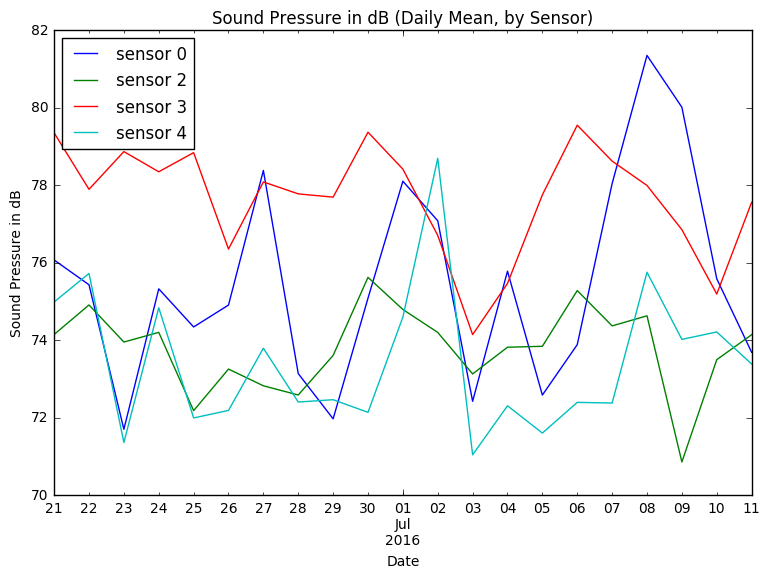

In [42]:
plt.figure(figsize=(9,6))
sensor0_daily['spl'].plot(label='sensor 0')
sensor2_daily['spl'].plot(label='sensor 2')
sensor3_daily['spl'].plot(label='sensor 3')
sensor4_daily['spl'].plot(label='sensor 4')
plt.xlabel('Date')
plt.ylabel('Sound Pressure in dB')
plt.title("Sound Pressure in dB (Daily Mean, by Sensor)")
plt.legend(loc='best')

### Figure 11: Sound Pressure in dB (Daily Mean, by Sensor)
- The above plot illustrates the daily mean SPL for each sensor.
- Sensor 3, which is located at the entrance of Red Hook Initiative on ground level, clearly shows higher readings than the others. This may be due to regular footfall in front of the building, or gathering of persons in front of the sensor at the regular reading times. 

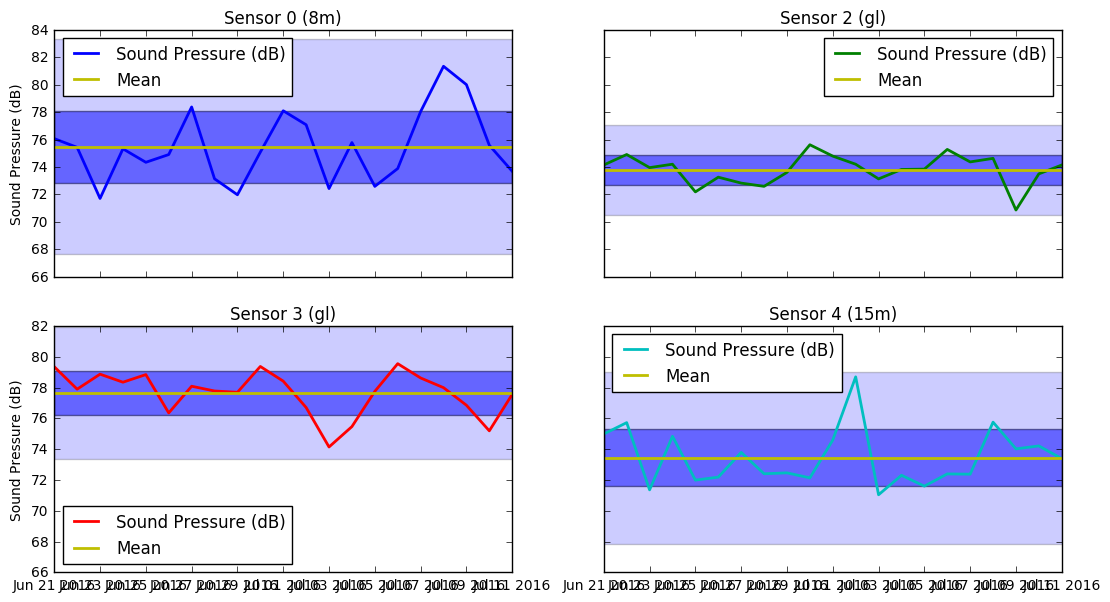

In [43]:
sigma_plot_4(sensor0_daily['spl'], sensor2_daily['spl'], sensor3_daily['spl'], sensor4_daily['spl'], 
             'Sound Pressure (dB)', 'Date')

### Figure 12: Sound Pressure Level in dB, Daily Mean, by Sensor
- The above plots show the SPL for each sensor. 
- When the mean and standard deviation are calculated for the daily mean of each sensor individually, the result produces no data points beyond the 3 sigma threshold. 

In [44]:
event_id_4(sensor0_daily['spl'], sensor2_daily['spl'], sensor3_daily['spl'], sensor4_daily['spl'],
            'spl', 'spl_daily_mean_events_bysensor')
#Test to show no events beyond 3 sigma threshold

,sensor,spl
dt,,


# 311 Data

In [45]:
data_path2 = os.getenv("PUIDATA")+"/311_Service_Requests_062116-071116.csv"
#data path for 311 data

In [46]:
complaint_data = pd.read_csv(data_path2, parse_dates=True, index_col='Created Date')
# creating dataframe with 311 data, call from PUIdata envar

In [47]:
complaint_data = complaint_data.sort_index(ascending=True)

In [48]:
complaints_June_22 = complaint_data.ix["2016/06/22"]
#creating a new DataFrame for specific complaint date

In [49]:
complaints_June_22.head(2)

,Unique Key,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,...,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
Created Date,,,,,,,,,,,,,,,,,,,,,
2016-06-22 00:00:00,33663183,06/12/2016 12:00:00 AM,DOHMH,Department of Health and Mental Hygiene,Rodent,Condition Attracting Rodents,3+ Family Apt. Building,11231,322 BOND STREET,BOND STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.679740,-73.989869,"(40.679739517014596, -73.98986894867262)"
2016-06-22 08:10:56,33663657,06/22/2016 09:04:06 AM,NYPD,New York City Police Department,Noise - Commercial,Banging/Pounding,Club/Bar/Restaurant,11231,SMITH STREET,SMITH STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.681955,-73.993698,"(40.68195482217686, -73.99369762776111)"


## Complaint Review
- Using NYC Open Data portal, I generated a dataset for all 311 complaints from 06/26/16 through 07/12/16 for ZIPCODE 11231 in Redhook (the zip location of all 4 sensors)
- Based on the events identified for both Particle Contents and SPL, I carefully reviewed the complaints for both spatial and temporal relation to the events. This was done by using Google Maps. 
- Upon review, I could find no 311 complaint that corresponded spacially and temporally to the sensor reading events.
- Limits: This process would have been more computationally efficient if I established a radius around the lat-long coordinated of the sensors, then compared that to the lat-long coords of the 311 complaints, and geocoded the complaints by address with missing lat-long coords. Due to time contraints, I was unable to execute this approach. 

# Weather Data


In [50]:
json_data = open(os.getenv("PUIDATA")+"/weather_API.json").read()
myAPI = json.loads(json_data)

# Calls in my weather API masked as 'myAPI'
# The weather data analyzed was sourced from Weather Underground
# data dictionary: https://www.wunderground.com/weather/api/d/docs?d=data/history&MR=1

In [51]:
weather_Jun_26 = pd.read_json('http://api.wunderground.com/api/'+myAPI['myAPI']+
                              '/history_20160626/q/NY/Brooklyn.json')
weather_Jul_06 = pd.read_json('http://api.wunderground.com/api/'+myAPI['myAPI']+
                              '/history_20160706/q/NY/Brooklyn.json')
weather_Jul_07 = pd.read_json('http://api.wunderground.com/api/'+myAPI['myAPI']+
                              '/history_20160707/q/NY/Brooklyn.json')
weather_Jul_08 = pd.read_json('http://api.wunderground.com/api/'+myAPI['myAPI']+
                              '/history_20160708/q/NY/Brooklyn.json')
weather_Jul_10 = pd.read_json('http://api.wunderground.com/api/'+myAPI['myAPI']+
                              '/history_20160710/q/NY/Brooklyn.json')
weather_Jul_11 = pd.read_json('http://api.wunderground.com/api/'+myAPI['myAPI']+
                              '/history_20160711/q/NY/Brooklyn.json')

In [52]:
con_events_all_readings['General_Conditions'] = 0
con_events_all_readings['Temperature'] = 0
con_events_all_readings['Humidity'] = 0

In [53]:
weather_Jun_26['history']

dailysummary      [{u'maxpressurem': u'1024', u'maxdewptm': u'17...
date              {u'mday': u'26', u'hour': u'12', u'min': u'00'...
features                                                        NaN
observations      [{u'heatindexm': u'-9999', u'windchillm': u'-9...
termsofService                                                  NaN
utcdate           {u'mday': u'26', u'hour': u'16', u'min': u'00'...
version                                                         NaN
Name: history, dtype: object

In [54]:
# weather_Jun_26['history']['observations']
# The above code, if run, would display all fields of all historical measurements for the given dataframe, 
# below I will filter down to just the 3 fields I'm interested in.

In [55]:
def weather_reading_time_id(hour):
    return ((hour*60)-15)/20

#The weather readings are recorded every 20 minutes, beginning at 00:15
#This function identifies the weather reading associated with the sensor record by hour

In [56]:
def weather_call(num, datetime, element, fieldname, table, target_df):
    target_df.set_value(datetime, element, 
                 table['history']['observations'][weather_reading_time_id(target_df.index[num].hour)][fieldname])

In [57]:
weather_dict = {'0': weather_Jun_26,
              '1':weather_Jul_06,
              '2':weather_Jul_07,
               '3':weather_Jul_08,
               '4':weather_Jul_08,
               '5':weather_Jul_10,
               '6':weather_Jul_11,
               '7':weather_Jul_11}

three_sigma_dt = {'0': '2016-06-27 20:00:00',
                  '1': '2016-07-06 12:00:00',
                  '2': '2016-07-07 16:00:00',
                  '3': '2016-07-08 08:00:00',
                  '4': '2016-07-08 16:00:00',
                  '5': '2016-07-10 08:00:00',
                  '6': '2016-07-11 08:00:00',
                  '7': '2016-07-11 12:00:00'}

In [58]:
for x in range(0,8):
    counter=str(x)
    weather_call(x, three_sigma_dt[counter], 'General_Conditions', 'icon', weather_dict[counter], 
                 con_events_all_readings)
    weather_call(x, three_sigma_dt[counter], 'Temperature', 'tempi', weather_dict[counter], 
                 con_events_all_readings)
    weather_call(x, three_sigma_dt[counter], 'Humidity', 'hum', weather_dict[counter], 
                 con_events_all_readings)

In [59]:
con_events_all_readings

,sensor,con,General_Conditions,Temperature,Humidity
dt,,,,,
2016-06-27 20:00:00,sensor_0,42612.26500,clear,75.2,47
2016-07-06 12:00:00,sensor_4,13388.50000,clear,89.6,43
2016-07-07 16:00:00,sensor_4,13499.98500,mostlycloudy,84.2,66
2016-07-08 08:00:00,sensor_4,30462.65750,partlycloudy,78.8,78
2016-07-08 16:00:00,sensor_4,23540.73000,partlycloudy,80.6,74
2016-07-10 08:00:00,sensor_4,18395.09500,cloudy,78.8,61
2016-07-11 08:00:00,sensor_4,12186.73375,partlycloudy,69.8,78
2016-07-11 12:00:00,sensor_4,17538.62250,partlycloudy,78.8,54


## Weather Review
- The above table containts the 8 particular content event data points along with the corresponding weather readings for each date. 
- Limits: This table shows only the weather readings for 8 days. In order to accurately determine the correlation between weather readings and sensor readings, much more data must be analyzed. 
    -Further exploration: I would analyze weather patterns on days where sensor readings were within 1 standard deviaton from the mean. Additionally, I would include more than 3 weather measurements. Without extensive domain knowledge in meteorology, I only included fields which were familiar. Secondly, weather such as rain and wind may have an effect on the SPL readings, which is something I would explore further. 
#### Additional Comments
- Given that the building type for the 4 sensors was provided, I did not explore PLUTO data. 
- Mapping the sensor points and complaint points may be beneficial in further analysis, however, upon manual review i did not find any links between the two. 
- Additionally, spatially analyzing noise compaints could provide insight as to where additional sensors could be placed. 